<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/ipm_divergences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Critics in IPMs variational bounds on $f$-divergences

Author: Mihaela Rosca 

This colab uses a simple example (two 1-d distributions) to show how the critics of various IPMs (Wasserstein distance and MMD) look like. We also look at how smooth estimators (neural nets) can estimte density ratios which are not 
smooth, and how that can be useful in providing a good learning signal for a model.

In [ ]:
import jax
import random
import numpy as np
import jax.numpy as jnp

import seaborn as sns
import matplotlib.pyplot as plt

import scipy

In [ ]:
!pip install -qq dm-haiku
!pip install -qq optax

     |████████████████████████████████| 284 kB 7.9 MB/s 
     |████████████████████████████████| 118 kB 9.1 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 


In [ ]:
try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq dm-haiku
    import haiku as hk
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

In [ ]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

# KL and non overlapping distributions

* non overlapping distributions (visual)
* explain ratio will be infinity - integral
* move the distributions closer and they will not have signal

In [ ]:
import scipy.stats

In [ ]:
from scipy.stats import truncnorm
from scipy.stats import beta

In [ ]:
#  We allow a displacement from 0 of the beta distribution.
class TranslatedBeta:
    def __init__(self, a, b, expand_dims=False, displacement=0):
        self._a = a
        self._b = b
        self.expand_dims = expand_dims
        self.displacement = displacement

    def rvs(self, size):
        val = beta.rvs(self._a, self._b, size=size) + self.displacement
        return np.expand_dims(val, axis=1) if self.expand_dims else val

    def pdf(self, x):
        return beta.pdf(x - self.displacement, self._a, self._b)

In [ ]:
p_param1 = 3
p_param2 = 5

q_param1 = 2
q_param2 = 3


start_p = 0
start_r = 1
start_q = 2

p_dist = TranslatedBeta(p_param1, p_param2, displacement=start_p)
q_dist = TranslatedBeta(q_param1, q_param2, displacement=start_q)
r_dist = TranslatedBeta(q_param1, q_param2, displacement=start_r)

([], <a list of 0 Text major ticklabel objects>)

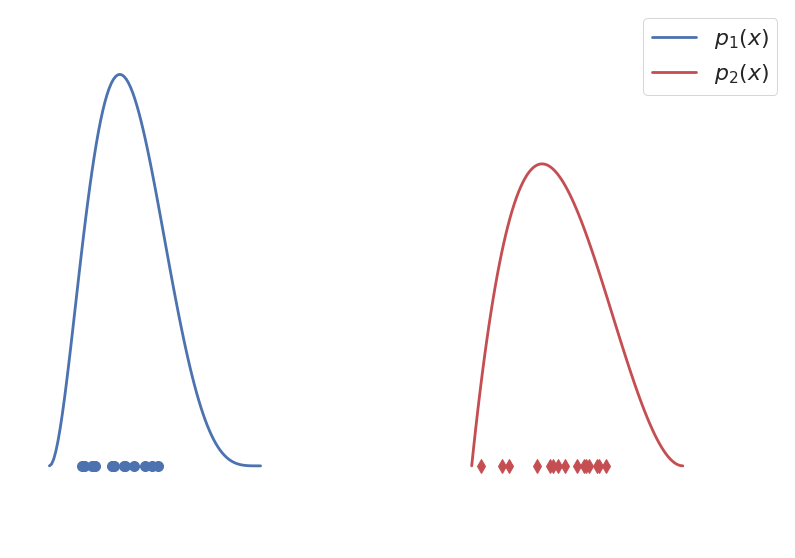

In [ ]:
plt.figure(figsize=(14, 10))

p_x_samples = p_dist.rvs(size=15)
q_x_samples = q_dist.rvs(size=15)

p_linspace_x = np.linspace(start_p, start_p + 1, 100)
p_x_pdfs = p_dist.pdf(p_linspace_x)

q_linspace_x = np.linspace(start_q, start_q + 1, 100)
q_x_pdfs = q_dist.pdf(q_linspace_x)

plt.plot(p_linspace_x, p_x_pdfs, "b", label=r"$p_1(x)$")
plt.plot(p_x_samples, [0] * len(p_x_samples), "bo", ms=10)

plt.plot(q_linspace_x, q_x_pdfs, "r", label=r"$p_2(x)$")
plt.plot(q_x_samples, [0] * len(q_x_samples), "rd", ms=10)

plt.ylim(-0.5, 2.7)
plt.xlim(-0.2, 3.5)
plt.axis("off")
plt.legend()
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

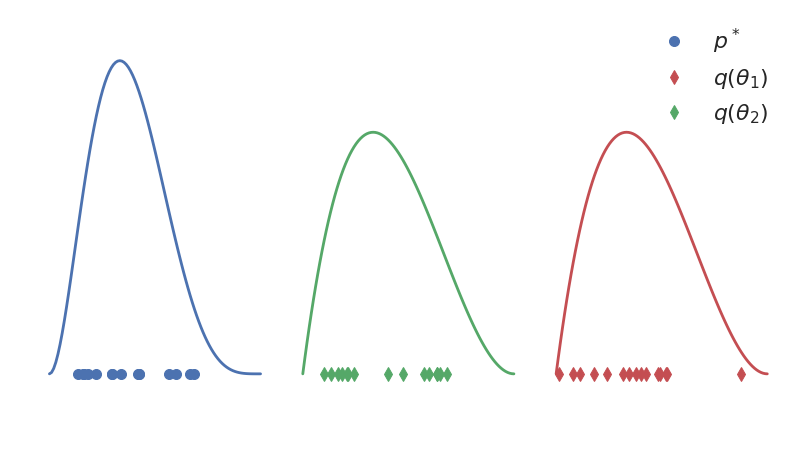

In [ ]:
plt.figure(figsize=(14, 8))

local_start_p = 0
local_start_r = 1.2
local_start_q = 2.4

local_p_dist = TranslatedBeta(p_param1, p_param2, displacement=local_start_p)
local_q_dist = TranslatedBeta(q_param1, q_param2, displacement=local_start_q)
local_r_dist = TranslatedBeta(q_param1, q_param2, displacement=local_start_r)

p_linspace_x = np.linspace(local_start_p, local_start_p + 1, 100)
q_linspace_x = np.linspace(local_start_q, local_start_q + 1, 100)
r_linspace_x = np.linspace(local_start_r, local_start_r + 1, 100)

p_x_pdfs = local_p_dist.pdf(p_linspace_x)
q_x_pdfs = local_q_dist.pdf(q_linspace_x)
r_x_pdfs = local_r_dist.pdf(r_linspace_x)

plt.plot(p_linspace_x, p_x_pdfs, "b")
plt.plot(q_linspace_x, q_x_pdfs, "r")
plt.plot(r_linspace_x, r_x_pdfs, "g")

num_samples = 15
plt.plot(local_p_dist.rvs(size=num_samples), [0] * num_samples, "bo", ms=10, label=r"$p^*$")
plt.plot(local_q_dist.rvs(size=num_samples), [0] * num_samples, "rd", ms=10, label=r"$q(\theta_1)$")
plt.plot(local_r_dist.rvs(size=num_samples), [0] * num_samples, "gd", ms=10, label=r"$q(\theta_2)$")

plt.ylim(-0.5, 2.7)
plt.xlim(-0.2, 3.5)
plt.axis("off")
plt.legend(framealpha=0)
plt.xticks([])
plt.yticks([])

# Approximation of the ratio using the f-gan approach

In [ ]:
model_transform = hk.without_apply_rng(
    hk.transform(
        lambda *args, **kwargs: hk.Sequential(
            [hk.Linear(10), jax.nn.relu, hk.Linear(10), jax.nn.tanh, hk.Linear(40), hk.Linear(1)]
        )(*args, **kwargs)
    )
)

In [ ]:
BATCH_SIZE = 100
NUM_UPDATES = 1000

In [ ]:
dist1 = TranslatedBeta(p_param1, p_param2, expand_dims=True, displacement=start_p)
dist2 = TranslatedBeta(q_param1, q_param2, expand_dims=True, displacement=start_q)

In [ ]:
@jax.jit
def estimate_kl(params, dist1_batch, dist2_batch):
    dist1_logits = model_transform.apply(params, dist1_batch)
    dist2_logits = model_transform.apply(params, dist2_batch)
    return jnp.mean(dist1_logits - jnp.exp(dist2_logits - 1))

In [ ]:
def update(params, opt_state, dist1_batch, dist2_batch):
    model_loss = lambda *args: -estimate_kl(*args)
    loss, grads = jax.value_and_grad(model_loss, has_aux=False)(params, dist1_batch, dist2_batch)
    params_update, new_opt_state = optim.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, params_update)
    return loss, new_params, new_opt_state

In [ ]:
NUM_UPDATES = 200

In [ ]:
rng = jax.random.PRNGKey(1)
init_model_params = model_transform.init(rng, dist1.rvs(BATCH_SIZE))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3132: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


In [ ]:
params = init_model_params
optim = optax.adam(learning_rate=0.0005, b1=0.9, b2=0.999)
opt_state = optim.init(init_model_params)

for i in range(NUM_UPDATES):
    # Get a new batch of data
    x = dist1.rvs(BATCH_SIZE)
    y = dist2.rvs(BATCH_SIZE)
    loss, params, opt_state = update(params, opt_state, x, y)

    if i % 50 == 0:
        print("Loss at {}".format(i))
        print(loss)

Loss at 0
1.2917138
Loss at 50
0.28676474
Loss at 100
-0.056605633
Loss at 150
-0.54646695


In [ ]:
plotting_x = np.expand_dims(np.linspace(-1.0, 3.5, 100), axis=1)

#  TODO: how do you get the ratio values form the estimate - need to check the fgan paper
ratio_values = model_transform.apply(params, plotting_x)
# ratio_values = 1 + np.log(model_transform.apply(params, plotting_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


([], <a list of 0 Text major ticklabel objects>)

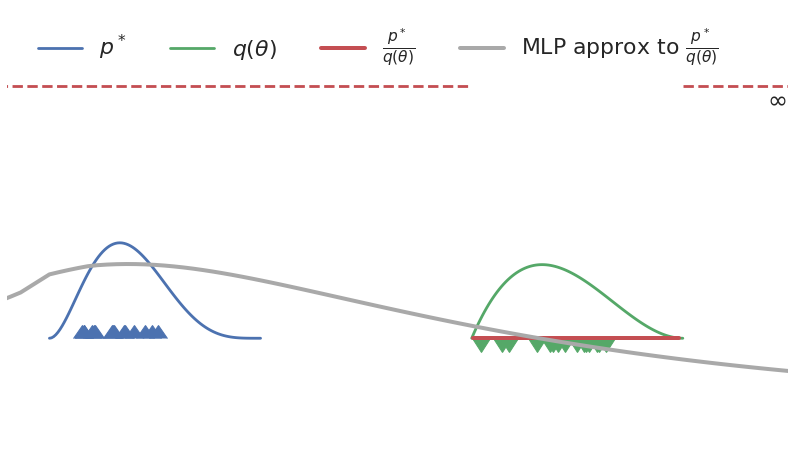

In [ ]:
plt.figure(figsize=(14, 8))


p_linspace_x = np.linspace(start_p, start_p + 1, 100)
q_linspace_x = np.linspace(start_q, start_q + 1, 100)

plt.plot(p_linspace_x, p_x_pdfs, "b", label=r"$p^*$")
plt.plot(p_x_samples, [0] * len(p_x_samples), color="b", marker=10, linestyle="None", ms=18)

plt.plot(q_linspace_x, q_x_pdfs, "g", label=r"$q(\theta)$")
plt.plot(q_x_samples, [0] * len(q_x_samples), color="g", marker=11, linestyle="None", ms=18)

x = np.linspace(-1, 3.5, 200)

ratio = p_dist.pdf(x) / q_dist.pdf(x)

plt.hlines(6.1, -0.6, start_q, linestyles="--", color="r")
plt.hlines(6.1, start_q + 1, 3.5, linestyles="--", color="r")
plt.text(3.4, 5.6, r"$\infty$")

plt.plot(x, ratio, "r", label=r"$\frac{p^*}{q(\theta)}$", linewidth=4)
plt.plot(
    plotting_x, ratio_values[:, 0].T, color="darkgray", label=r"MLP approx to $\frac{p^*}{q(\theta)}$", linewidth=4
)

plt.ylim(-2.5, 8)
plt.xlim(-0.2, 3.5)
plt.axis("off")

plt.legend(loc="upper center", bbox_to_anchor=(0.35, 0.0, 0.25, 1.0), ncol=4, framealpha=0)
plt.xticks([])
plt.yticks([])

## Gradients 


In order to see why the learned density ratio has useful properties for learning, we can plot the gradients of the learned density ratio across the input space

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


([], <a list of 0 Text major ticklabel objects>)

<Figure size 1008x576 with 0 Axes>

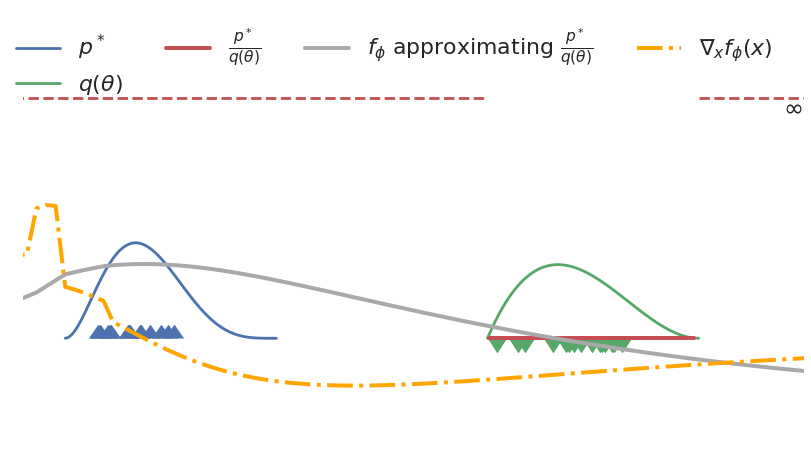

In [ ]:
plt.figure(figsize=(14, 8))

grad_fn = jax.grad(lambda x: model_transform.apply(params, x)[0])

grad_values = jax.vmap(grad_fn)(plotting_x)


plt.figure(figsize=(14, 8))


p_linspace_x = np.linspace(start_p, start_p + 1, 100)
q_linspace_x = np.linspace(start_q, start_q + 1, 100)

plt.plot(p_linspace_x, p_x_pdfs, "b", label=r"$p^*$")
plt.plot(p_x_samples, [0] * len(p_x_samples), color="b", marker=10, linestyle="None", ms=18)

plt.plot(q_linspace_x, q_x_pdfs, "g", label=r"$q(\theta)$")
plt.plot(q_x_samples, [0] * len(q_x_samples), color="g", marker=11, linestyle="None", ms=18)

x = np.linspace(-1, 3.5, 200)

ratio = p_dist.pdf(x) / q_dist.pdf(x)

plt.hlines(5.8, -0.6, start_q, linestyles="--", color="r")
plt.hlines(5.8, start_q + 1, 3.5, linestyles="--", color="r")
plt.text(3.4, 5.4, r"$\infty$")

plt.plot(x, ratio, "r", label=r"$\frac{p^*}{q(\theta)}$", linewidth=4)
plt.plot(
    plotting_x,
    ratio_values[:, 0].T,
    color="darkgray",
    label=r"$f_{\phi}$ approximating $\frac{p^*}{q(\theta)}$",
    linewidth=4,
)
plt.plot(plotting_x, grad_values[:, 0].T, color="orange", label=r"$\nabla_{x} f_{\phi}(x)$", linewidth=4, ls="-.")


plt.ylim(-2.5, 8)
plt.xlim(-0.2, 3.5)
plt.axis("off")

plt.legend(loc="upper center", bbox_to_anchor=(0.35, 0.0, 0.25, 1.0), ncol=4, framealpha=0)
plt.xticks([])
plt.yticks([])

# Wasserstein distance for the same two distributions


Computing the Wasserstein critic in 1 dimension. Reminder that the Wasserstein distance is defined as:
$$
W(p, q) = \sup_{\|\|f\|\|_{Lip} \le 1} E_p(x) f(x) - E_q(x) f(x)
$$

The below code finds the values of f evaluated at the samples of the two distributions. This vector is computed to maximise the empirical (Monte Carlo) estimate of the IPM:
$$
  \frac{1}{n}\sum_{i=1}^n f(x_i) - \frac{1}{m}\sum_{i=1}^m f(y_j)
$$

where $x_i$ are samples from the first distribution, while $y_j$ are samples
from the second distribution. Since we want the function $f$ to be 1-Lipschitz, 
an inequality constraint is added to ensure that for all two choices of samples 
in the two distributions, $\forall x \in \{x_1, ... x_n, y_1, ... y_m\}, \forall y \in \{x_1, ... x_n, y_1, ... y_m\}$ 
$$
  f(x) - f(y) \le |x - y| \\
  f(y) - f(x) \le |x - y| \\
$$

This maximisation needs to occur under the constraint that the function $f$
is 1-Lipschitz, which is ensured uisng the constraint on the linear program.

Note: This approach does not scale to large datasets.

Thank you to Arthur Gretton and Dougal J Sutherland for this version of the code.


In [ ]:
from scipy.optimize import linprog

In [ ]:
def get_W_witness_spectrum(p_samples, q_samples):
    n = len(p_samples)
    m = len(q_samples)
    X = np.concatenate([p_samples, q_samples], axis=0)

    ## AG:  repeat [-1/n] n times
    c = np.array(n * [-1 / n] + m * [1 / m])
    A_ub, b_ub = [], []
    for i in range(n + m):
        for j in range(n + m):
            if i == j:
                continue
            z = np.zeros(n + m)
            z[i] = 1
            z[j] = -1
            A_ub.append(z)
            b_ub.append(np.abs(X[i] - X[j]))

    ## AG: Minimize: c^T * x
    ## Subject to: A_ub * x <= b_ub
    res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, method="simplex", options={"tol": 1e-5})
    a = res["x"]

    ## AG:  second argument xs to be passed into the internal
    ## function.
    def witness_spectrum(x):
        diff = np.abs(x - X[:, np.newaxis])
        one = np.min(a[:, np.newaxis] + diff, axis=0)
        two = np.max(a[:, np.newaxis] - diff, axis=0)
        return one, two

    return witness_spectrum

In [ ]:
x = np.linspace(-1, 3.5, 100)

wass_estimate = get_W_witness_spectrum(p_x_samples + start_p, q_x_samples + start_q)(x)

wa, wb = wass_estimate
w = (wa + wb) / 2
w -= w.mean()

([], <a list of 0 Text major ticklabel objects>)

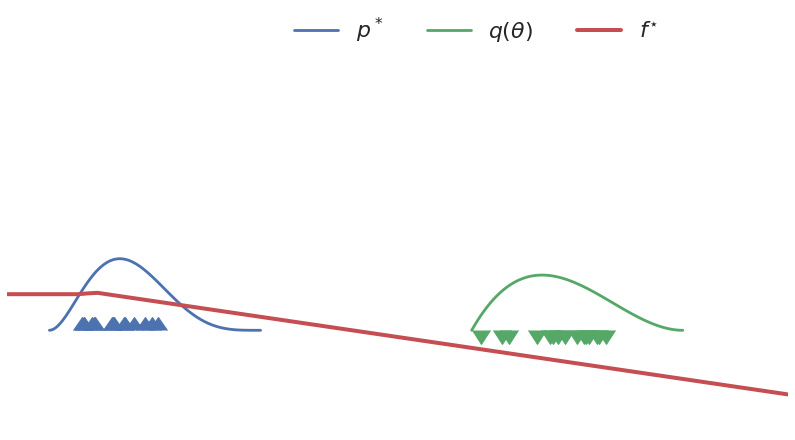

In [ ]:
plt.figure(figsize=(14, 6))

display_offset = 0.8

plt.plot(p_linspace_x, display_offset + p_x_pdfs, "b", label=r"$p^*$")
plt.plot(p_x_samples, [display_offset] * len(p_x_samples), color="b", marker=10, linestyle="None", ms=18)

plt.plot(q_linspace_x, display_offset + q_x_pdfs, "g", label=r"$q(\theta)$")
plt.plot(q_x_samples, [display_offset] * len(q_x_samples), color="g", marker=11, linestyle="None", ms=18)

x = np.linspace(-1, 3.5, 100)
plt.plot(x, w + display_offset, "r", label=r"$f^{\star}$", linewidth=4)

plt.ylim(-2.5, 8)
plt.xlim(-0.2, 3.5)
plt.axis("off")
plt.legend(loc="upper center", bbox_to_anchor=(0.35, 0.0, 0.5, 1.34), ncol=3, framealpha=0)
plt.xticks([])
plt.yticks([])

## MMD computation

The MMD is an IPM defined as:
$$
MMD(p, q) = \sup_{\|\|f\|\|_{\mathcal{H}} \le 1} E_p(x) f(x) - E_q(x) f(x)
$$

where $\mathcal{H}$ is a RKHS. Using the mean embedding operators in an RKHS, we can write:
$$
 E_p(x) f(x) = \langle f, \mu_p \rangle \\
 E_q(x) f(x) = \langle f, \mu_q \rangle \\
$$

replacing in the MMD:

$$
MMD(p, q) = \sup_{\|\|f\|\|_{\mathcal{H}} \le 1} \langle f, \mu_p - \mu_q \rangle
$$

which means that 
$$
f = \frac{\mu_p - \mu_q}{\|\|\mu_p - \mu_q\|\|_{\mathcal{H}}}
$$

To obtain an estimate of $f$ evaluated at $x$ we use that:
$$
f(x) = \frac{\mathbb{E}_{p(y)} k(x, y) - \mathbb{E}_{q(y)} k(x, y)}{\|\|\mu_p - \mu_q\|\|_{\mathcal{H}}}
$$

to estimate $\|\|\mu_p - \mu_q\|\|_{\mathcal{H}}$ we use:

$$
\|\|\mu_p - \mu_q\|\|_{\mathcal{H}} = \langle \mu_p - \mu_q, \mu_p - \mu_q \rangle = \langle \mu_p, \mu_p \rangle  + \langle \mu_q, \mu_q \rangle 
    - 2  \langle \mu_p, \mu_q \rangle 
$$


To estimate the dot products, we use:
$$
\langle \mu_p, \mu_p \rangle = E_p(x) \mu_p(x) =  E_p(x) \langle \mu_p, k(x, \cdot) \rangle =  E_p(x) E_p(x') k(x, x')
$$

For more details see the slides here: http://www.gatsby.ucl.ac.uk/~gretton/coursefiles/lecture5_distribEmbed_1.pdf


In [ ]:
def covariance(kernel_fn, X, Y):
    num_rows = len(X)
    num_cols = len(Y)
    K = np.zeros((num_rows, num_cols))
    for i in range(num_rows):
        for j in range(num_cols):
            K[i, j] = kernel_fn(X[i], Y[j])

    return K

In [ ]:
def gaussian_kernel(x1, x2, gauss_var=0.1, height=2.2):
    return height * np.exp(-np.linalg.norm(x1 - x2) ** 2 / gauss_var)

indices
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))


([], <a list of 0 Text major ticklabel objects>)

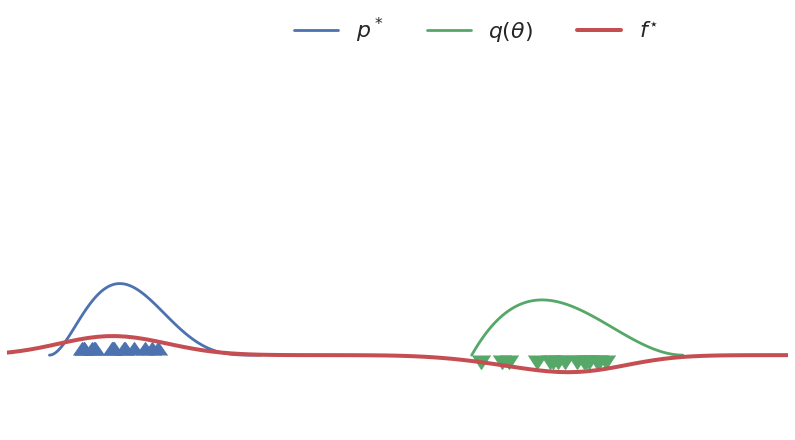

In [ ]:
def evaluate_mmd_critic(p_samples, q_samples):
    n = p_samples.shape[0]
    m = q_samples.shape[0]

    p_cov = covariance(gaussian_kernel, p_samples, p_samples)
    print("indices")
    print(np.diag_indices(n))
    p_samples_norm = np.sum(p_cov) - np.sum(p_cov[np.diag_indices(n)])
    p_samples_norm /= n * (n - 1)

    q_cov = covariance(gaussian_kernel, q_samples, q_samples)
    q_samples_norm = np.sum(q_cov) - np.sum(q_cov[np.diag_indices(m)])
    q_samples_norm /= m * (m - 1)

    p_q_cov = covariance(gaussian_kernel, p_samples, q_samples)
    p_q_norm = np.sum(p_q_cov)
    p_q_norm /= n * m

    norm = p_samples_norm + q_samples_norm - 2 * p_q_norm

    def critic(x):
        p_val = np.mean([gaussian_kernel(x, y) for y in p_samples])
        q_val = np.mean([gaussian_kernel(x, y) for y in q_samples])
        return (p_val - q_val) / norm

    return critic


critic_fn = evaluate_mmd_critic(p_x_samples, q_x_samples)

plt.figure(figsize=(14, 6))

display_offset = 0

plt.plot(p_linspace_x, display_offset + p_x_pdfs, "b", label=r"$p^*$")
plt.plot(p_x_samples, [display_offset] * len(p_x_samples), color="b", marker=10, linestyle="None", ms=18)

plt.plot(q_linspace_x, display_offset + q_x_pdfs, "g", label=r"$q(\theta)$")
plt.plot(q_x_samples, [display_offset] * len(q_x_samples), color="g", marker=11, linestyle="None", ms=18)

x = np.linspace(-1, 3.5, 100)
plt.plot(
    start_p + x, np.array([critic_fn(x_val) for x_val in x]) + display_offset, "r", label=r"$f^{\star}$", linewidth=4
)

plt.ylim(-2.5, 8)
plt.xlim(-0.2, 3.5)
plt.axis("off")
plt.legend(loc="upper center", bbox_to_anchor=(0.35, 0.0, 0.5, 1.34), ncol=3, framealpha=0)
plt.xticks([])
plt.yticks([])